### 导入数据

In [1]:
%matplotlib inline
import os
import glob
import xgboost
import operator
import numpy as np
from pylab import *
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression,Lasso,LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel,RFECV
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier,VotingClassifier
from sklearn.model_selection import GridSearchCV,KFold, cross_val_predict,StratifiedKFold,train_test_split,cross_val_score,LeaveOneOut
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,plot_confusion_matrix,auc,roc_auc_score,roc_curve,plot_roc_curve,ConfusionMatrixDisplay,mean_squared_error
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.combine import SMOTETomek,SMOTEENN
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
import missingno as msno
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings(action='ignore')

#导入数据
df = pd.read_excel(r"F:\Desktop\Kidney\51例\dp.xlsx")
target=df.iloc[:,1:2]
features=df.iloc[:,2:102]
features_names=list(features.columns)

#不标准化数据
X_data_2 = features
y_data_2 = target

#标准化所有数据
scaler = StandardScaler()#scaler = MinMaxScaler()#scaler = RobustScaler()
X_data_1 = pd.DataFrame(scaler.fit_transform(features),columns=features_names)
y_data_1 = target

### 随机森林+RFECV

In [39]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

scaler = StandardScaler()
sm = SMOTE(random_state=5)
clf = RandomForestClassifier(criterion='gini', random_state=1,n_jobs=-1,class_weight="balanced")
estimator = ([("stand",scaler),("sample", sm),("clf", clf)])
pipeline = Mypipeline(estimator)

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
rfecv.fit(X_data_2, y_data_2)

names = list(X_data_2.columns[rfecv.support_])
print('选择的特征子集为：', names)
print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
g_scores = rfecv.grid_scores_
indices = np.argsort(g_scores)[::-1]
print("Grid_Score: %f" % (g_scores[indices[0]]))
select_features = X_data_2.loc[:, names]

选择的特征子集为： ['original_glcm_DifferenceAverage', 'original_glcm_Idn', 'original_glcm_MaximumProbability', 'original_gldm_DependenceVariance', 'original_glrlm_ShortRunEmphasis', 'original_glszm_GrayLevelNonUniformityNormalized', 'original_glszm_GrayLevelVariance', 'original_glszm_SmallAreaHighGrayLevelEmphasis']
RFECV 选择出的特征个数 ： 8
Grid_Score: 0.489583


In [31]:
model = Pipeline([("stand",scaler),("sample", sm),("clf", clf)])
score={'AUC':'roc_auc', 'RECALL':'recall','PRECISION':'precision','F1':'f1'}
params = {'clf__criterion' : ['gini'],
          'clf__max_features' : ["auto", "sqrt", "log2"],
          'clf__max_depth': [2,4,6,8],
          'clf__min_samples_leaf' : [1,3,5,7],
          'clf__min_samples_split' : [2,4,6,8],
          'clf__n_estimators': [9,10,11,12]}
grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1, 
                               refit='AUC',
                               return_train_score=True)
grid_search.fit(select_features, y_data_2)
print("模型最佳参数为：",grid_search.best_params_)
print("模型最佳AUC为：", grid_search.best_score_) 
select_features = X_data_2.loc[:, names]

模型最佳参数为： {'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 6, 'clf__n_estimators': 11}
模型最佳AUC为： 0.725


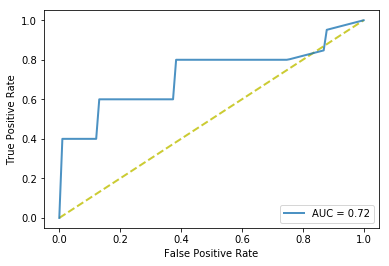

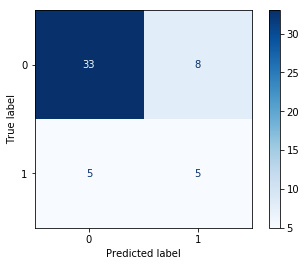

,Accuracy,Auc,F1-score,Precision,Sensitivity(TPR),Specificity(TNR)
Random forest,0.74±0.1,0.72±0.25,0.373333,0.3,0.5±0.45,0.8±0.06


In [38]:
best_clf=RandomForestClassifier(criterion='gini', max_depth=4, max_features='auto', min_samples_leaf=1,
                                min_samples_split=6, n_estimators=11, random_state=1,n_jobs=-1,class_weight="balanced")
cons = 0
acc = []
pre = []
f1 = []
sen = []
spe = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in cv.split(select_features, y_data_2): 
    X_train = select_features.iloc[train_index] 
    y_train = y_data_2.iloc[train_index] 
    X_test = select_features.iloc[test_index]
    y_test = y_data_2.iloc[test_index]
        
    scaler = StandardScaler().fit(X_train)
    X_train_scaler = pd.DataFrame(scaler.transform(X_train))
    X_test_scaler = pd.DataFrame(scaler.transform(X_test))
    
    sm = SMOTE(random_state=5)
    X_resampled, y_resampled = sm.fit_resample(X_train_scaler, y_train)
    
    best_clf.fit(X_resampled, y_resampled)
    y_pred = best_clf.predict(X_test_scaler)
    proba = best_clf.predict_proba(X_test_scaler)[:,1]
        
    fpr,tpr,threshold = roc_curve(y_test, proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(roc_auc_score(y_test,proba))
    acc.append(accuracy_score(y_test, y_pred))
    pre.append(precision_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sen.append(tp/(tp+fn))
    spe.append(tn/(fp+tn))
        
    class_names=['0','1']
    a=confusion_matrix(y_test,y_pred)
    cons=cons+a
#ROC曲线        
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, label=r'AUC = %0.2f'% (mean_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()
#混淆矩阵        
disp = ConfusionMatrixDisplay(confusion_matrix=cons,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 
     
result_dict = {'Accuracy': ['±'.join([str(round(np.mean(acc),2)),str(round(np.std(acc),2))])], 
                'Auc': ['±'.join([str(round(np.mean(aucs),2)),str(round(np.std(aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(sen),2)),str(round(np.std(sen),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(spe),2)),str(round(np.std(spe),2))])], 
                'Precision': [np.mean(pre)],
                'F1-score': [np.mean(f1)]
                }
    
result = pd.DataFrame(result_dict, index=['Random forest'])
result

### SVM+RFECV

In [27]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

sm = SMOTE(random_state=5)
clf = SVC(kernel = "linear",random_state=1,probability=True)
estimator = ([("sample", sm),("clf", clf)])
pipeline = Mypipeline(estimator)

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
rfecv.fit(X_data_1, y_data_1)

names = list(X_data_1.columns[rfecv.support_])
print('选择的特征子集为：', names)
print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
g_scores = rfecv.grid_scores_
indices = np.argsort(g_scores)[::-1]
print("Grid_Score: %f" % (g_scores[indices[0]]))

#网格搜索最佳参数
select_features = X_data_1.loc[:, names]
model = Pipeline([("sample", sm),("clf", clf)])
score={'AUC':'roc_auc', 'RECALL':'recall','PRECISION':'precision','F1':'f1'}
params = {'clf__kernel' : ['linear'],
          'clf__C' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5]}
grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1, 
                               refit='AUC',
                               return_train_score=True)
grid_search.fit(select_features, y_data_1)
print("模型最佳参数为：",grid_search.best_params_)
print("模型最佳AUC为：", grid_search.best_score_)

选择的特征子集为： ['original_firstorder_10Percentile', 'original_firstorder_InterquartileRange', 'original_firstorder_Maximum', 'original_glcm_ClusterProminence', 'original_glcm_Contrast', 'original_glcm_Idmn', 'original_glcm_JointEnergy', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glrlm_GrayLevelNonUniformityNormalized', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_glrlm_ShortRunEmphasis', 'original_glszm_GrayLevelNonUniformity', 'original_glszm_LowGrayLevelZoneEmphasis', 'original_glszm_ZoneEntropy', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow']
RFECV 选择出的特征个数 ： 16
Grid_Score: 0.487500
模型最佳参数为： {'clf__C': 3, 'clf__kernel': 'linear'}
模型最佳AUC为： 0.7652777777777777


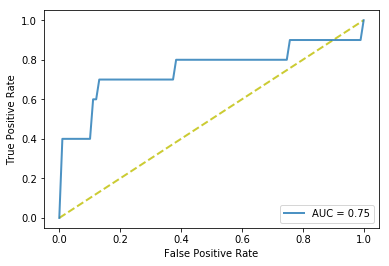

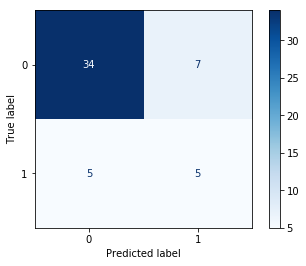

,Accuracy,Auc,F1-score,Precision,Sensitivity(TPR),Specificity(TNR)
SVM,0.761818,0.752778,0.406667,0.35,0.5,0.827778


In [28]:
best_clf=SVC(kernel = "linear",C=3,random_state=1,probability=True)

cons = 0
acc = []
pre = []
f1 = []
sen = []
spe = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in cv.split(select_features, y_data_1): 
    X_train = select_features.iloc[train_index] 
    y_train = y_data_2.iloc[train_index] 
    X_test = select_features.iloc[test_index]
    y_test = y_data_2.iloc[test_index]
        
    scaler = StandardScaler().fit(X_train)
    X_train_scaler = pd.DataFrame(scaler.transform(X_train))
    X_test_scaler = pd.DataFrame(scaler.transform(X_test))
    
    sm = SMOTE(random_state=5)
    X_resampled, y_resampled = sm.fit_resample(X_train_scaler, y_train)
    
    best_clf.fit(X_resampled, y_resampled)
    y_pred = best_clf.predict(X_test_scaler)
    proba = best_clf.predict_proba(X_test_scaler)[:,1]
        
    fpr,tpr,threshold = roc_curve(y_test, proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(roc_auc_score(y_test,proba))
    acc.append(accuracy_score(y_test, y_pred))
    pre.append(precision_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sen.append(tp/(tp+fn))
    spe.append(tn/(fp+tn))
        
    class_names=['0','1']
    a=confusion_matrix(y_test,y_pred)
    cons=cons+a
#ROC曲线        
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, label=r'AUC = %0.2f'% (mean_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()
#混淆矩阵        
disp = ConfusionMatrixDisplay(confusion_matrix=cons,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 
    
result_dict = {'Accuracy': [np.mean(acc)], 
                'Auc': [np.mean(aucs)], 
                'Sensitivity(TPR)': [np.mean(sen)], 
                'Specificity(TNR)': [np.mean(spe)],
                'Precision': [np.mean(pre)],
                'F1-score': [np.mean(f1)]
                }
    
result = pd.DataFrame(result_dict, index=['SVM'])
result

### 逻辑回归+RFECV

In [79]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

sm = SMOTE(random_state=5)
clf =  LogisticRegression()
estimator = ([("sample", sm),("clf", clf)])
pipeline = Mypipeline(estimator)

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
rfecv.fit(X_data_1, y_data_1)

names = list(X_data_1.columns[rfecv.support_])
print('选择的特征子集为：', names)
print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
g_scores = rfecv.grid_scores_
indices = np.argsort(g_scores)[::-1]
print("Grid_Score: %f" % (g_scores[indices[0]]))

#网格搜索最佳参数
select_features = X_data_1.loc[:, names]
model = Pipeline([("stand",scaler),("sample", sm),("clf", clf)])
score={'AUC':'roc_auc', 'RECALL':'recall','PRECISION':'precision','F1':'f1'}
params = {'clf__penalty': ['l2','l1'],
          'clf__C':  [50,100,150],
         'clf__solver': ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}
grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1, 
                               refit='AUC',
                               return_train_score=True)
grid_search.fit(select_features, y_data_1)
print("模型最佳参数为：",grid_search.best_params_)
print("模型最佳AUC为：", grid_search.best_score_)

选择的特征子集为： ['original_firstorder_90Percentile', 'original_firstorder_Range', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_Contrast', 'original_glcm_Idmn', 'original_gldm_DependenceVariance', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_glrlm_ShortRunEmphasis', 'original_glszm_GrayLevelNonUniformity', 'original_glszm_GrayLevelNonUniformityNormalized', 'original_glszm_LowGrayLevelZoneEmphasis', 'original_glszm_SmallAreaEmphasis', 'original_shape_Flatness', 'original_shape_Maximum2DDiameterRow']
RFECV 选择出的特征个数 ： 16
Grid_Score: 0.390278
模型最佳参数为： {'clf__C': 50, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}
模型最佳AUC为： 0.7194444444444444


In [95]:
#网格搜索最佳参数
select_features = X_data_1.loc[:, names]
model = Pipeline([("stand",scaler),("sample", sm),("clf", clf)])
score={'AUC':'roc_auc', 'RECALL':'recall','PRECISION':'precision','F1':'f1'}
params = {'clf__penalty': ['l1'],
          'clf__C':  [2000],
         'clf__solver': [ "liblinear"]}
grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1, 
                               refit='AUC',
                               return_train_score=True)
grid_search.fit(select_features, y_data_1)
print("模型最佳参数为：",grid_search.best_params_)
print("模型最佳AUC为：", grid_search.best_score_)

模型最佳参数为： {'clf__C': 2000, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
模型最佳AUC为： 0.7194444444444444


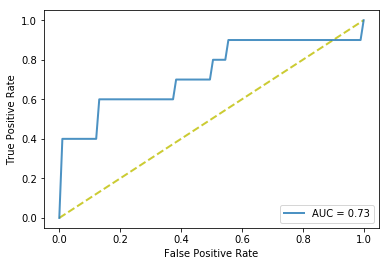

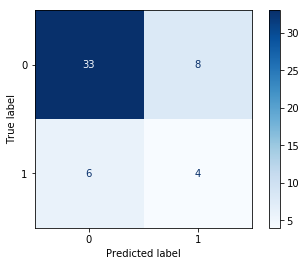

,Accuracy,Auc,F1-score,Precision,Sensitivity(TPR),Specificity(TNR)
LR,0.725455,0.731944,0.326667,0.283333,0.4,0.805556


In [98]:
best_clf=LogisticRegression(C=2000,penalty='l1',solver='liblinear')

cons = 0
acc = []
pre = []
f1 = []
sen = []
spe = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in cv.split(select_features, y_data_1): 
    X_train = select_features.iloc[train_index] 
    y_train = y_data_2.iloc[train_index] 
    X_test = select_features.iloc[test_index]
    y_test = y_data_2.iloc[test_index]
        
    scaler = StandardScaler().fit(X_train)
    X_train_scaler = pd.DataFrame(scaler.transform(X_train))
    X_test_scaler = pd.DataFrame(scaler.transform(X_test))
    
    sm = SMOTE(random_state=5)
    X_resampled, y_resampled = sm.fit_resample(X_train_scaler, y_train)
    
    best_clf.fit(X_resampled, y_resampled)
    y_pred = best_clf.predict(X_test_scaler)
    proba = best_clf.predict_proba(X_test_scaler)[:,1]
        
    fpr,tpr,threshold = roc_curve(y_test, proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(roc_auc_score(y_test,proba))
    acc.append(accuracy_score(y_test, y_pred))
    pre.append(precision_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sen.append(tp/(tp+fn))
    spe.append(tn/(fp+tn))
        
    class_names=['0','1']
    a=confusion_matrix(y_test,y_pred)
    cons=cons+a
#ROC曲线        
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, label=r'AUC = %0.2f'% (mean_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()
#混淆矩阵        
disp = ConfusionMatrixDisplay(confusion_matrix=cons,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 
    
result_dict = {'Accuracy': [np.mean(acc)], 
                'Auc': [np.mean(aucs)], 
                'Sensitivity(TPR)': [np.mean(sen)], 
                'Specificity(TNR)': [np.mean(spe)],
                'Precision': [np.mean(pre)],
                'F1-score': [np.mean(f1)]
                }
    
result = pd.DataFrame(result_dict, index=['LR'])
result

### XGBoost+RFECV

In [3]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

scaler = StandardScaler()
sm = SMOTE(random_state=5)
clf = xgboost.XGBClassifier(random_state=1,n_jobs=-1)
xgboost.set_config(verbosity=0)  
estimator = ([("stand",scaler),("sample", sm),("clf", clf)])
pipeline = Mypipeline(estimator)
    
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
rfecv.fit(X_data_2, y_data_2)
    
names = list(X_data_2.columns[rfecv.support_])
print('选择的特征子集为：', names)
print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
g_scores = rfecv.grid_scores_
indices = np.argsort(g_scores)[::-1]
print("Grid_Score: %f" % (g_scores[indices[0]]))

选择的特征子集为： ['original_firstorder_90Percentile', 'original_gldm_DependenceVariance']
RFECV 选择出的特征个数 ： 2
Grid_Score: 0.548611


In [5]:
select_features = X_data_2.loc[:, names]
model = Pipeline([("stand",scaler),("sample", sm),("clf", clf)])
score={'AUC':'roc_auc', 'RECALL':'recall','PRECISION':'precision','F1':'f1'}
params = {'clf__colsample_bytree' : [0.1,0.2],
          'clf__gamma' : [0.1,0.2],
          'clf__learning_rate' : [0.01,0.02],
          'clf__max_depth' : [1,2,3,4],
          'clf__min_child_weight' : [3,4,5],
          'clf__n_estimators' : [1,2,3,4],          
          'clf__reg_alpha' : [1,2,3,4],
          'clf__reg_lambda' : [2,3,4,5],
          'clf__subsample' : [0.9,1]}
grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1, 
                               refit='AUC',
                               return_train_score=True)
grid_search.fit(select_features, y_data_2)
print("模型最佳参数为：",grid_search.best_params_)
print("模型最佳AUC为：", grid_search.best_score_)

模型最佳参数为： {'clf__colsample_bytree': 0.1, 'clf__gamma': 0.1, 'clf__learning_rate': 0.01, 'clf__max_depth': 1, 'clf__min_child_weight': 3, 'clf__n_estimators': 3, 'clf__reg_alpha': 1, 'clf__reg_lambda': 2, 'clf__subsample': 0.9}
模型最佳AUC为： 0.7743055555555556


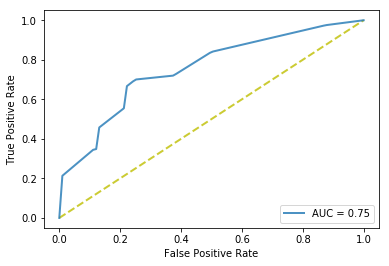

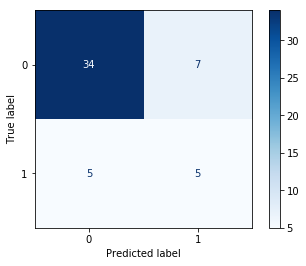

,Accuracy,Auc,Sensitivity(TPR),Specificity(TNR)
XGBoost,0.77±0.04,0.75±0.16,0.5±0.32,0.83±0.1


In [6]:
best_clf=xgboost.XGBClassifier(colsample_bytree=0.1, gamma=0.1, learning_rate=0.01, max_depth=3, 
                               min_child_weight=3, n_estimators=3, reg_alpha=1, reg_lambda=2, 
                               subsample=0.9, random_state=1,n_jobs=-1)
cons = 0
acc = []
pre = []
f1 = []
sen = []
spe = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in cv.split(select_features, y_data_2): 
    X_train = select_features.iloc[train_index] 
    y_train = y_data_2.iloc[train_index] 
    X_test = select_features.iloc[test_index]
    y_test = y_data_2.iloc[test_index]
        
    scaler = StandardScaler().fit(X_train)
    X_train_scaler = pd.DataFrame(scaler.transform(X_train))
    X_test_scaler = pd.DataFrame(scaler.transform(X_test))
    
    sm = SMOTE(random_state=5)
    X_resampled, y_resampled = sm.fit_resample(X_train_scaler, y_train)
    
    best_clf.fit(X_resampled, y_resampled)
    y_pred = best_clf.predict(X_test_scaler)
    proba = best_clf.predict_proba(X_test_scaler)[:,1]
        
    fpr,tpr,threshold = roc_curve(y_test, proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(roc_auc_score(y_test,proba))
    acc.append(accuracy_score(y_test, y_pred))
    pre.append(precision_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sen.append(tp/(tp+fn))
    spe.append(tn/(fp+tn))
        
    class_names=['0','1']
    a=confusion_matrix(y_test,y_pred)
    cons=cons+a
#ROC曲线        
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, label=r'AUC = %0.2f'% (mean_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()
#混淆矩阵        
disp = ConfusionMatrixDisplay(confusion_matrix=cons,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 
std_acc = np.std(acc) 
std_auc = np.std(aucs)   
std_sen = np.std(sen) 
std_spe = np.std(spe) 
result_dict = {'Accuracy': ['±'.join([str(round(np.mean(acc),2)),str(round(np.std(acc),2))])], 
                'Auc': ['±'.join([str(round(np.mean(aucs),2)),str(round(np.std(aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(sen),2)),str(round(np.std(sen),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(spe),2)),str(round(np.std(spe),2))])], 
                }
    
result = pd.DataFrame(result_dict, index=['XGBoost'])
result

### 特征可视化

<function matplotlib.pyplot.show>

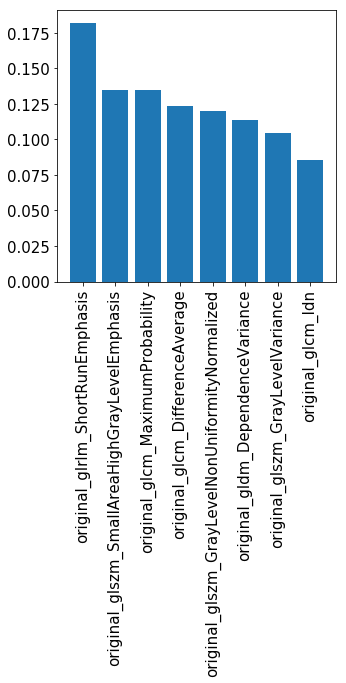

In [40]:
import matplotlib.pyplot as plt
clf = RandomForestClassifier(criterion='gini', random_state=1,n_jobs=-1,class_weight="balanced") 
clf.fit(select_features,y_data_2)
importances=clf.feature_importances_
indices=np.argsort(importances)[::-1]
features_names = list(X_data_2.columns[rfecv.support_])
names=[features_names[i] for i in indices]
matplotlib.rcParams.update({'font.size': 15})
#特征重要性排序图
plt.figure(figsize=(5,5))
plt.title=("Feature Importance")
plt.bar(range(select_features.shape[1]),importances[indices])
plt.xticks(range(select_features.shape[1]),names,rotation=90)
plt.show

TypeError: 'list' object is not callable

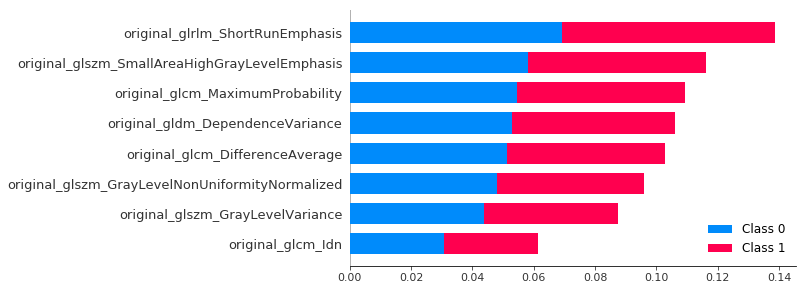

In [43]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(select_features)
shap.summary_plot(shap_values, select_features)

In [8]:
a=list(range(0,230,10))
a.extend(list(range(240,310,10)))
for i in a:
    print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
240
250
260
270
280
290
300


### 不同分类器设置不同随机种子并取均值

#### SVM

第 1 次循环
随机种子数为： 0
RFECV 选择出的特征个数 ： 7
选择的特征子集为： ['original_firstorder_Range', 'original_glcm_ClusterProminence', 'original_glcm_Idmn', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glszm_LowGrayLevelZoneEmphasis', 'original_glszm_ZoneEntropy', 'original_shape_Maximum2DDiameterColumn']
Grid_Score: 0.511111
模型最佳参数为： {'clf__C': 6, 'clf__kernel': 'linear'}
模型最佳AUC为： 0.638888888888889
第 2 次循环
随机种子数为： 10
RFECV 选择出的特征个数 ： 16
选择的特征子集为： ['original_firstorder_10Percentile', 'original_firstorder_InterquartileRange', 'original_firstorder_Maximum', 'original_glcm_ClusterProminence', 'original_glcm_Idmn', 'original_glcm_JointEnergy', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glrlm_GrayLevelNonUniformityNormalized', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_glrlm_ShortRunEmphasis', 'original_glszm_GrayLevelNonUniformity', 'original_glszm_GrayLevelNonUniformityNormalized', 'original_glszm_LowGrayLevelZoneEmphasis', 'original_glszm_ZoneEntropy', 'orig

模型最佳参数为： {'clf__C': 0.9, 'clf__kernel': 'linear'}
模型最佳AUC为： 0.5125
第 15 次循环
随机种子数为： 140
RFECV 选择出的特征个数 ： 3
选择的特征子集为： ['original_firstorder_Maximum', 'original_glcm_ClusterProminence', 'original_glcm_Idmn']
Grid_Score: 0.536111
模型最佳参数为： {'clf__C': 8, 'clf__kernel': 'linear'}
模型最佳AUC为： 0.6416666666666667
第 16 次循环
随机种子数为： 150
RFECV 选择出的特征个数 ： 2
选择的特征子集为： ['original_glszm_GrayLevelNonUniformity', 'original_shape_Maximum2DDiameterRow']
Grid_Score: 0.498611
模型最佳参数为： {'clf__C': 0.4, 'clf__kernel': 'linear'}
模型最佳AUC为： 0.7097222222222223
第 17 次循环
随机种子数为： 160
RFECV 选择出的特征个数 ： 5
选择的特征子集为： ['original_glcm_ClusterProminence', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glszm_GrayLevelNonUniformity', 'original_glszm_LowGrayLevelZoneEmphasis', 'original_shape_Maximum2DDiameterRow']
Grid_Score: 0.540278
模型最佳参数为： {'clf__C': 6, 'clf__kernel': 'linear'}
模型最佳AUC为： 0.6583333333333334
第 18 次循环
随机种子数为： 170
RFECV 选择出的特征个数 ： 7
选择的特征子集为： ['original_firstorder_Range', 'original_glcm_ClusterPro

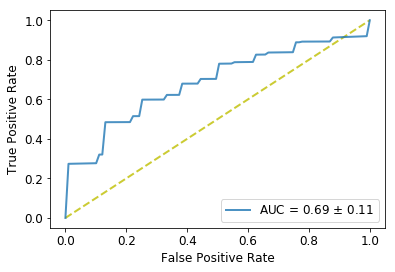

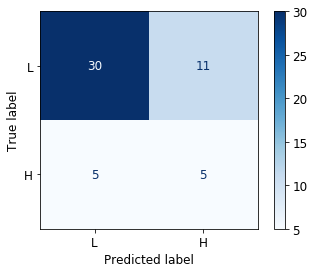

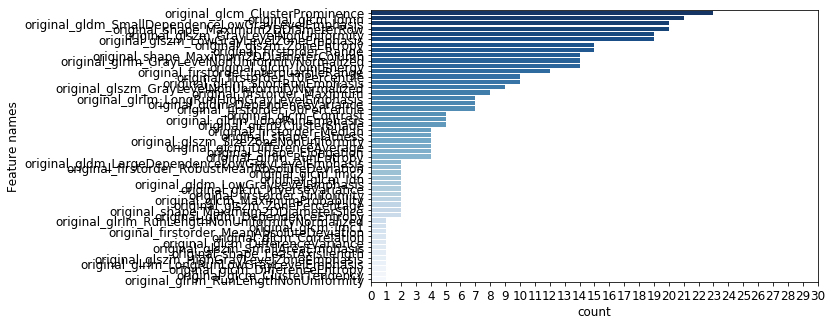

,Accuracy,Auc,F1 score,Sensitivity(TPR),Specificity(TNR)
SVM,0.69±0.11,0.69±0.11,0.41±0.09,0.54±0.13,0.72±0.15


In [2]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

svm_cons = 0
svm_accs = []
svm_aucs = [] 
svm_sens = []
svm_spes = []
svm_f1s = []
svm_tprs = []
n=0
svm_feature_set = []
mean_fpr = np.linspace(0, 1, 100) 
a=list(range(0,230,10))
a.extend(list(range(240,310,10)))
for i in a: 
    #统计循环次数
    n=n+1
    print('第',n,'次循环')
    print('随机种子数为：',i)
    
    #设置分类器
    sm = SMOTE(random_state=i)
    clf = SVC(kernel = "linear",random_state=1,class_weight="balanced",probability=True)
    estimator = ([("sample", sm),("clf", clf)])
    pipeline = Mypipeline(estimator)
    
    #svmECV特征选择
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
    rfecv.fit(X_data_1, y_data_1)
    print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
    names = list(X_data_1.columns[rfecv.support_])
    svm_feature_set.append(names)
    select_features = X_data_1.loc[:, names]
    print('选择的特征子集为：', names)
    g_scores = rfecv.grid_scores_
    indices = np.argsort(g_scores)[::-1]
    print("Grid_Score: %f" % (g_scores[indices[0]]))
    
    #模型网格寻优
    model = Pipeline([("sample", sm),("clf", clf)])
    score={'AUC':'roc_auc', 'ACCURACY':'accuracy', 'RECALL':'recall', 'F1':'f1'}
    params = {'clf__kernel' : ['linear'],
              'clf__C' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,4,6,8,10,20]}    
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score,
                               n_jobs=-1,
                               refit='AUC',
                               return_train_score=True)
    grid_search.fit(select_features, y_data_1)
    print("模型最佳参数为：",grid_search.best_params_)
    print("模型最佳AUC为：", grid_search.best_score_)
    
    #用最优模型训练结果
    best_clf = grid_search.best_estimator_
    con = 0
    acc = []
    auc_ = [] 
    sen = []
    spe = []
    f1 = []
    tpr_ = []         
    for train_index, test_index in cv.split(select_features, y_data_1): 
        X_train = select_features.iloc[train_index] 
        y_train = y_data_1.iloc[train_index] 
        X_test = select_features.iloc[test_index]
        y_test = y_data_1.iloc[test_index]
        
        best_clf.fit(X_train, y_train)
        y_pred = best_clf.predict(X_test)
        proba = best_clf.predict_proba(X_test)[:,1]
        fpr,tpr,threshold = roc_curve(y_test, proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        
        tpr_.append(interp_tpr) 
        acc.append(accuracy_score(y_test, y_pred))
        auc_.append(roc_auc_score(y_test,proba))        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sen.append(tp/(tp+fn))
        spe.append(tn/(fp+tn))
        f1.append(f1_score(y_test, y_pred))
        
        a=confusion_matrix(y_test,y_pred)
        con=con+a
   
    svm_tprs.append(np.mean(tpr_, axis=0))
    svm_accs.append(np.mean(acc))
    svm_aucs.append(np.mean(auc_))  
    svm_sens.append(np.mean(sen))
    svm_spes.append(np.mean(spe))
    svm_f1s.append(np.mean(f1))
    svm_cons=svm_cons+con
    
#ROC曲线 
matplotlib.rcParams.update({'font.size': 12})
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
svm_mean_tpr = np.mean(svm_tprs, axis=0)
svm_mean_tpr[-1] = 1.0
svm_mean_auc = auc(mean_fpr, svm_mean_tpr)
svm_std_auc = np.std(svm_aucs)
plt.plot(mean_fpr, svm_mean_tpr, label=r'AUC = %0.2f $\pm$ %0.2f'% (svm_mean_auc,svm_std_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()

#混淆矩阵      
class_names=['L','H']
disp = ConfusionMatrixDisplay(confusion_matrix=np.around(svm_cons/n),display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 

#特征频率图可视化
svm_select_names = pd.concat([pd.DataFrame(svm_feature_set[i],columns=['Feature names']) for i in range(n)])
svm_result=pd.DataFrame(pd.value_counts(svm_select_names['Feature names']))
plt.figure(figsize=(8, 5))
f = sns.countplot(y='Feature names',data=svm_select_names, order=svm_result.index, palette='Blues_r')
                  #'Blues_r')
f.set_xticks(range(n+1))
plt.show()

#模型结果
svm_result_dict = {'Accuracy': ['±'.join([str(round(np.mean(svm_accs),2)),str(round(np.std(svm_accs),2))])], 
                'Auc': ['±'.join([str(round(np.mean(svm_aucs),2)),str(round(np.std(svm_aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(svm_sens),2)),str(round(np.std(svm_sens),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(svm_spes),2)),str(round(np.std(svm_spes),2))])], 
                'F1 score': ['±'.join([str(round(np.mean(svm_f1s),2)),str(round(np.std(svm_f1s),2))])] 
                }

result_svm = pd.DataFrame(svm_result_dict, index=['SVM'])
result_svm

In [3]:
svm_mean_tpr

array([0.        , 0.27367003, 0.27400673, 0.27434343, 0.27468013,
       0.27501684, 0.27535354, 0.27569024, 0.27602694, 0.27636364,
       0.27670034, 0.32037037, 0.32070707, 0.48420875, 0.48427609,
       0.48434343, 0.48441077, 0.48447811, 0.48454545, 0.48461279,
       0.48468013, 0.48474747, 0.51481481, 0.51488215, 0.51494949,
       0.59835017, 0.59841751, 0.59848485, 0.59855219, 0.59861953,
       0.59868687, 0.59875421, 0.59882155, 0.62222222, 0.62228956,
       0.6223569 , 0.62242424, 0.62249158, 0.67922559, 0.67929293,
       0.67936027, 0.67942761, 0.67949495, 0.67956229, 0.70296296,
       0.7030303 , 0.70309764, 0.70316498, 0.70323232, 0.70329966,
       0.78010101, 0.78030303, 0.78050505, 0.78070707, 0.78090909,
       0.78777778, 0.7879798 , 0.78818182, 0.78838384, 0.78858586,
       0.78878788, 0.7889899 , 0.82585859, 0.82606061, 0.82626263,
       0.82646465, 0.83666667, 0.83686869, 0.83707071, 0.83727273,
       0.83747475, 0.83767677, 0.83787879, 0.83808081, 0.83828

In [9]:
svm_mean_auc=0.6863408495731725

In [10]:
svm_std_auc=0.11225360009700967

In [17]:
svm_result

,Feature names
original_glcm_ClusterProminence,23
original_glcm_Idmn,21
original_shape_Maximum2DDiameterRow,20
original_gldm_SmallDependenceLowGrayLevelEmphasis,20
original_glszm_LowGrayLevelZoneEmphasis,19
original_glszm_GrayLevelNonUniformity,19
original_firstorder_Range,15
original_glszm_ZoneEntropy,15
original_glrlm_GrayLevelNonUniformityNormalized,14
original_glcm_JointEnergy,14


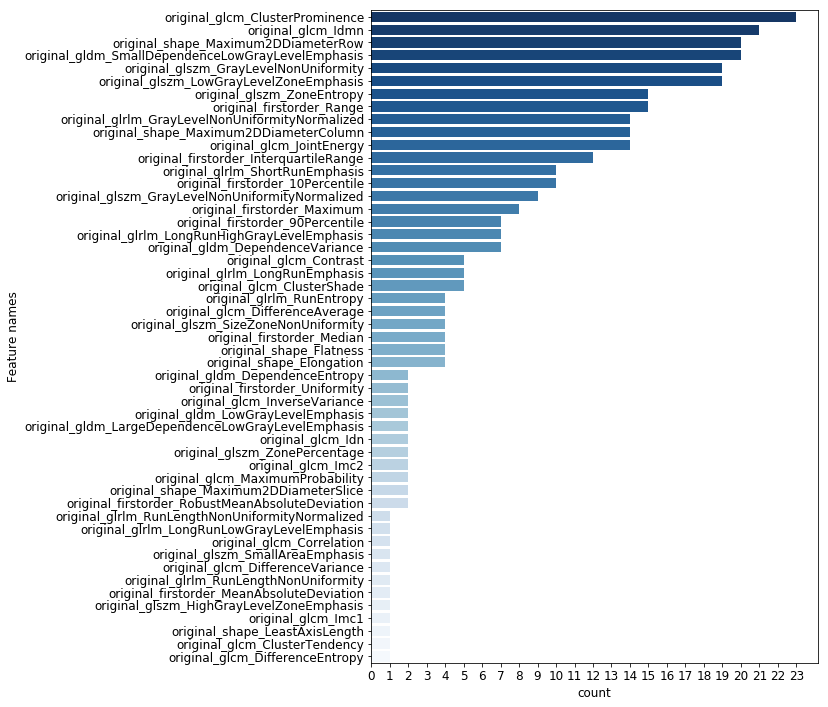

In [19]:
#特征频率图可视化
select_names = pd.concat([pd.DataFrame(feature_set[i],columns=['Feature names']) for i in range(n)])
result=pd.DataFrame(pd.value_counts(select_names['Feature names']))
plt.figure(figsize=(8, 12))
f = sns.countplot(y='Feature names',data=select_names, order=result.index, palette='Blues_r')
                  #'Blues_r')
f.set_xticks(range(24))
plt.show()


#### 随机森林

第 1 次循环
随机种子数为： 0
RFECV 选择出的特征个数 ： 1
选择的特征子集为： ['original_firstorder_Range']
Grid_Score: 0.464583
模型最佳参数为： {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 11, 'clf__min_samples_split': 3, 'clf__n_estimators': 9}
模型最佳AUC为： 0.763888888888889
第 2 次循环
随机种子数为： 10
RFECV 选择出的特征个数 ： 38
选择的特征子集为： ['original_firstorder_90Percentile', 'original_firstorder_Kurtosis', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Range', 'original_firstorder_RootMeanSquared', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idmn', 'original_glcm_Idn', 'original_glcm_Imc1', 'original_glcm_InverseVariance', 'original_glcm_JointAverage', 'original_glcm_JointEnergy', 'original_glcm_MaximumProbability', 'original_gldm_DependenceVariance', 'original_gldm_LargeDependen

模型最佳参数为： {'clf__criterion': 'gini', 'clf__max_depth': 1, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 11, 'clf__min_samples_split': 3, 'clf__n_estimators': 5}
模型最佳AUC为： 0.701388888888889
第 10 次循环
随机种子数为： 90
RFECV 选择出的特征个数 ： 8
选择的特征子集为： ['original_glcm_Correlation', 'original_glcm_Idmn', 'original_gldm_DependenceVariance', 'original_glrlm_ShortRunEmphasis', 'original_glszm_GrayLevelNonUniformityNormalized', 'original_glszm_GrayLevelVariance', 'original_glszm_SmallAreaHighGrayLevelEmphasis', 'original_shape_Elongation']
Grid_Score: 0.517361
模型最佳参数为： {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 3, 'clf__n_estimators': 11}
模型最佳AUC为： 0.7395833333333334
第 11 次循环
随机种子数为： 100
RFECV 选择出的特征个数 ： 6
选择的特征子集为： ['original_glcm_DifferenceAverage', 'original_glcm_Idmn', 'original_glrlm_ShortRunEmphasis', 'original_glszm_GrayLevelVariance', 'original_glszm_SizeZoneNonUniformityNormalized', 'original_glszm_Smal

模型最佳参数为： {'clf__criterion': 'gini', 'clf__max_depth': 1, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 3, 'clf__n_estimators': 9}
模型最佳AUC为： 0.7090277777777778
第 17 次循环
随机种子数为： 160
RFECV 选择出的特征个数 ： 100
选择的特征子集为： ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_Mean', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendenc

模型最佳参数为： {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 8, 'clf__n_estimators': 5}
模型最佳AUC为： 0.5513888888888889
第 20 次循环
随机种子数为： 190
RFECV 选择出的特征个数 ： 83
选择的特征子集为： ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_Mean', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceA

模型最佳参数为： {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 7, 'clf__n_estimators': 11}
模型最佳AUC为： 0.7451388888888889
第 29 次循环
随机种子数为： 280
RFECV 选择出的特征个数 ： 65
选择的特征子集为： ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_Median', 'original_firstorder_Range', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idmn', 'original_glcm_Idn', 'o

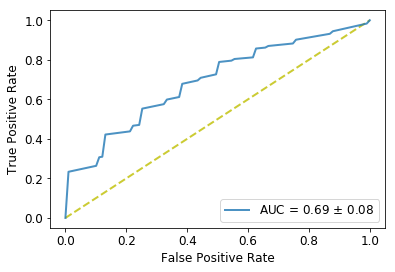

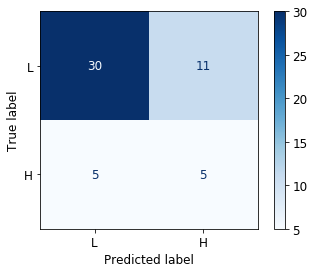

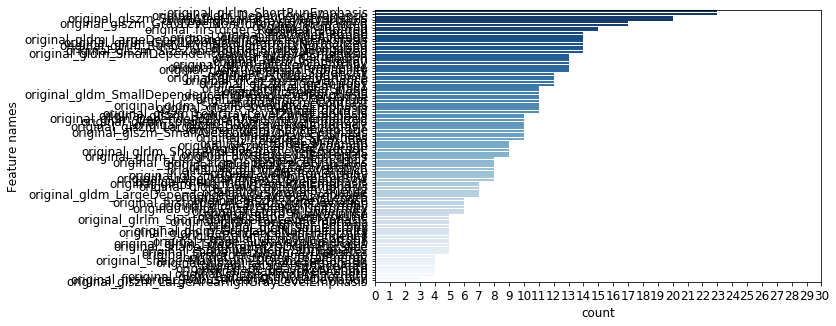

,Accuracy,Auc,F1 score,Sensitivity(TPR),Specificity(TNR)
RF,0.68±0.06,0.69±0.08,0.33±0.11,0.46±0.16,0.73±0.08


In [6]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

rf_cons = 0
rf_accs = []
rf_aucs = [] 
rf_sens = []
rf_spes = []
rf_f1s = []
rf_tprs = []
n=0
rf_feature_set = []
mean_fpr = np.linspace(0, 1, 100)       
for i in range(0,300,10):    
    #统计循环次数
    n=n+1
    print('第',n,'次循环')
    print('随机种子数为：',i)
    
    #设置分类器
    sm = SMOTE(random_state=i)
    clf = RandomForestClassifier(criterion='gini', random_state=1,n_jobs=-1,class_weight="balanced")
    estimator = ([("sample", sm),("clf", clf)])
    pipeline = Mypipeline(estimator)
    
    #RFECV特征选择
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
    rfecv.fit(X_data_1, y_data_1)
    print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
    names = list(X_data_1.columns[rfecv.support_])
    rf_feature_set.append(names)
    select_features = X_data_1.loc[:, names]
    print('选择的特征子集为：', names)
    g_scores = rfecv.grid_scores_
    indices = np.argsort(g_scores)[::-1]
    print("Grid_Score: %f" % (g_scores[indices[0]]))
    
    #模型网格寻优
    model = Pipeline([("sample", sm),("clf", clf)])
    score={'AUC':'roc_auc', 'ACCURACY':'accuracy', 'RECALL':'recall', 'F1':'f1'}
    params = {'clf__criterion' : ['gini'],
          'clf__max_features' : ["auto", "sqrt", "log2"],
          'clf__max_depth': [1,3,5,7,9],
          'clf__min_samples_leaf' : [2,4,6,8,10,11],
          'clf__min_samples_split' : [1,3,5,7,8],
          'clf__n_estimators': [5,7,9,11,12,15]}   
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1, 
                               refit='AUC',
                               return_train_score=True)
    grid_search.fit(select_features, y_data_1)
    print("模型最佳参数为：",grid_search.best_params_)
    print("模型最佳AUC为：", grid_search.best_score_)
    
    #用最优模型训练结果
    best_clf = grid_search.best_estimator_
    con = 0
    acc = []
    auc_ = [] 
    sen = []
    spe = []
    f1 = []
    tpr_ = []         
    for train_index, test_index in cv.split(select_features, y_data_1): 
        X_train = select_features.iloc[train_index] 
        y_train = y_data_1.iloc[train_index] 
        X_test = select_features.iloc[test_index]
        y_test = y_data_1.iloc[test_index]
        
        best_clf.fit(X_train, y_train)
        y_pred = best_clf.predict(X_test)
        proba = best_clf.predict_proba(X_test)[:,1]
        fpr,tpr,threshold = roc_curve(y_test, proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        
        tpr_.append(interp_tpr) 
        acc.append(accuracy_score(y_test, y_pred))
        auc_.append(roc_auc_score(y_test,proba))        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sen.append(tp/(tp+fn))
        spe.append(tn/(fp+tn))
        f1.append(f1_score(y_test, y_pred))
        
        a=confusion_matrix(y_test,y_pred)
        con=con+a
   
    rf_tprs.append(np.mean(tpr_, axis=0))
    rf_accs.append(np.mean(acc))
    rf_aucs.append(np.mean(auc_))  
    rf_sens.append(np.mean(sen))
    rf_spes.append(np.mean(spe))
    rf_f1s.append(np.mean(f1))
    rf_cons=rf_cons+con
    
#ROC曲线 
matplotlib.rcParams.update({'font.size': 12})
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
rf_mean_tpr = np.mean(rf_tprs, axis=0)
rf_mean_tpr[-1] = 1.0
rf_mean_auc = auc(mean_fpr, rf_mean_tpr)
rf_std_auc = np.std(rf_aucs)
plt.plot(mean_fpr, rf_mean_tpr, label=r'AUC = %0.2f $\pm$ %0.2f'% (rf_mean_auc,rf_std_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()

#混淆矩阵      
class_names=['L','H']
disp = ConfusionMatrixDisplay(confusion_matrix=np.around(rf_cons/n),display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 

#特征频率图可视化
rf_select_names = pd.concat([pd.DataFrame(rf_feature_set[i],columns=['Feature names']) for i in range(n)])
rf_result=pd.DataFrame(pd.value_counts(rf_select_names['Feature names']))
plt.figure(figsize=(8, 5))
f = sns.countplot(y='Feature names',data=rf_select_names, order=rf_result.index, palette='Blues_r')
                  #'Blues_r')
f.set_xticks(range(n+1))
plt.show()

#模型结果
rf_result_dict = {'Accuracy': ['±'.join([str(round(np.mean(rf_accs),2)),str(round(np.std(rf_accs),2))])], 
                'Auc': ['±'.join([str(round(np.mean(rf_aucs),2)),str(round(np.std(rf_aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(rf_sens),2)),str(round(np.std(rf_sens),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(rf_spes),2)),str(round(np.std(rf_spes),2))])], 
                'F1 score': ['±'.join([str(round(np.mean(rf_f1s),2)),str(round(np.std(rf_f1s),2))])] 
                }

rf_result = pd.DataFrame(rf_result_dict, index=['RF'])
rf_result

In [7]:
rf_mean_tpr

array([0.        , 0.23335578, 0.23671156, 0.24006734, 0.24342312,
       0.2467789 , 0.25013468, 0.25349046, 0.25684624, 0.26020202,
       0.2635578 , 0.30691358, 0.30956229, 0.42180415, 0.42380191,
       0.42579966, 0.42779742, 0.42979517, 0.43179293, 0.43379068,
       0.43578844, 0.4377862 , 0.46645062, 0.46849166, 0.47053271,
       0.55287117, 0.55610189, 0.55933261, 0.56256333, 0.56579405,
       0.56902477, 0.57225549, 0.57548621, 0.59871693, 0.60194765,
       0.60517837, 0.60840909, 0.61163981, 0.67836099, 0.68177128,
       0.68518158, 0.68859187, 0.69200216, 0.69541246, 0.70882275,
       0.71233405, 0.71584536, 0.71935666, 0.72286797, 0.72637927,
       0.78897026, 0.79064093, 0.79231161, 0.79398228, 0.79565296,
       0.8039903 , 0.80535794, 0.80672559, 0.80809323, 0.80946088,
       0.81082852, 0.81219617, 0.8569224 , 0.85849206, 0.86006173,
       0.86163139, 0.86986772, 0.87143739, 0.87300705, 0.87457672,
       0.87614638, 0.87771605, 0.87928571, 0.88085538, 0.88242

In [11]:
rf_mean_tpr=[0.        , 0.23335578, 0.23671156, 0.24006734, 0.24342312,
       0.2467789 , 0.25013468, 0.25349046, 0.25684624, 0.26020202,
       0.2635578 , 0.30691358, 0.30956229, 0.42180415, 0.42380191,
       0.42579966, 0.42779742, 0.42979517, 0.43179293, 0.43379068,
       0.43578844, 0.4377862 , 0.46645062, 0.46849166, 0.47053271,
       0.55287117, 0.55610189, 0.55933261, 0.56256333, 0.56579405,
       0.56902477, 0.57225549, 0.57548621, 0.59871693, 0.60194765,
       0.60517837, 0.60840909, 0.61163981, 0.67836099, 0.68177128,
       0.68518158, 0.68859187, 0.69200216, 0.69541246, 0.70882275,
       0.71233405, 0.71584536, 0.71935666, 0.72286797, 0.72637927,
       0.78897026, 0.79064093, 0.79231161, 0.79398228, 0.79565296,
       0.8039903 , 0.80535794, 0.80672559, 0.80809323, 0.80946088,
       0.81082852, 0.81219617, 0.8569224 , 0.85849206, 0.86006173,
       0.86163139, 0.86986772, 0.87143739, 0.87300705, 0.87457672,
       0.87614638, 0.87771605, 0.87928571, 0.88085538, 0.88242504,
       0.90151996, 0.90423441, 0.90694885, 0.9096633 , 0.91237775,
       0.91509219, 0.91780664, 0.92052108, 0.92323553, 0.92594998,
       0.92866442, 0.93137887, 0.94439634, 0.94791887, 0.9514414 ,
       0.95496392, 0.95848645, 0.96200898, 0.96553151, 0.96905403,
       0.97257656, 0.97609909, 0.97962161, 0.98314414, 1.        ]

In [12]:
rf_mean_auc=0.6903454012629097

In [13]:
rf_std_auc=0.07952403366735758

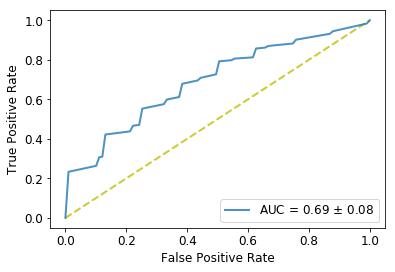

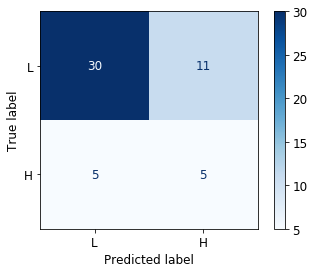

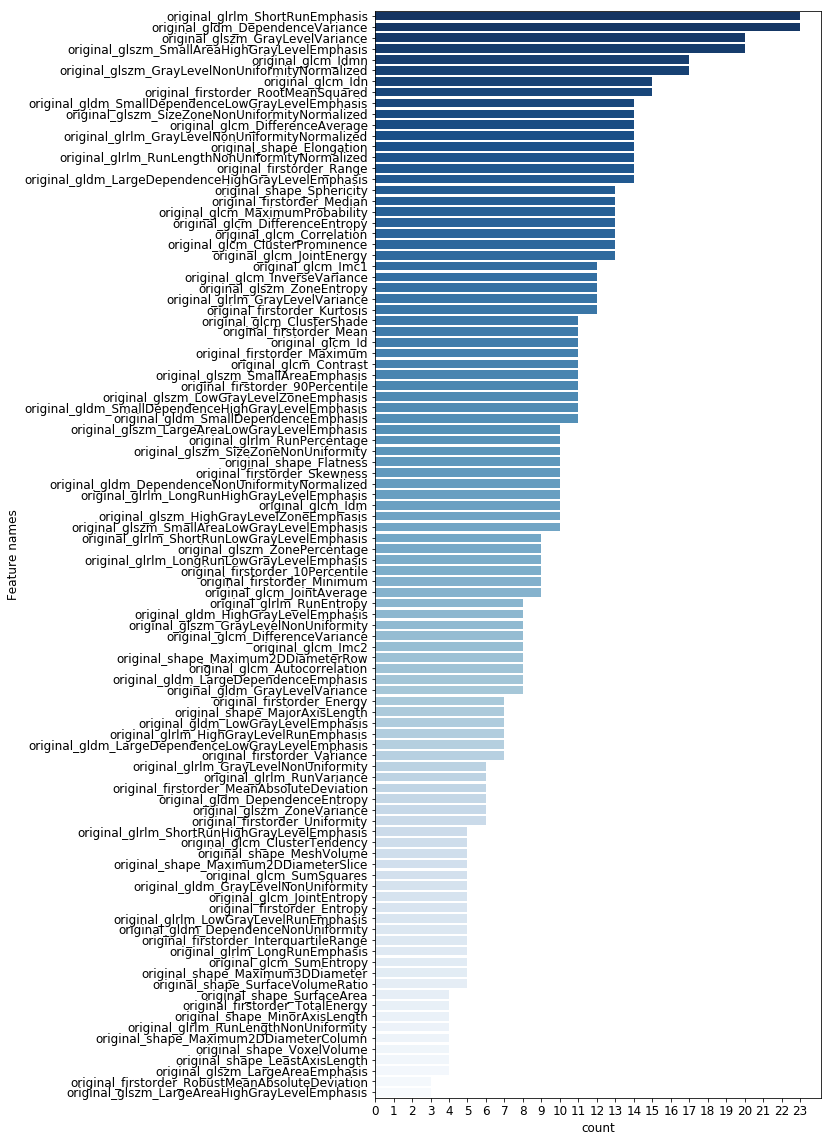

,Accuracy,Auc,F1 score,Sensitivity(TPR),Specificity(TNR)
RF,0.68±0.06,0.69±0.08,0.33±0.11,0.46±0.16,0.73±0.08


In [15]:
#ROC曲线 
matplotlib.rcParams.update({'font.size': 12})
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
rf_mean_tpr = np.mean(rf_tprs, axis=0)
rf_mean_tpr[-1] = 1.0
rf_mean_auc = auc(mean_fpr, rf_mean_tpr)
rf_std_auc = np.std(rf_aucs)
plt.plot(mean_fpr, rf_mean_tpr, label=r'AUC = %0.2f $\pm$ %0.2f'% (rf_mean_auc,rf_std_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()

#混淆矩阵      
class_names=['L','H']
disp = ConfusionMatrixDisplay(confusion_matrix=np.around(rf_cons/n),display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 

#特征频率图可视化
rf_select_names = pd.concat([pd.DataFrame(rf_feature_set[i],columns=['Feature names']) for i in range(n)])
rf_result=pd.DataFrame(pd.value_counts(rf_select_names['Feature names']))
plt.figure(figsize=(8, 20))
f = sns.countplot(y='Feature names',data=rf_select_names, order=rf_result.index, palette='Blues_r')
                  #'Blues_r')
f.set_xticks(range(24))
plt.show()

#模型结果
rf_result_dict = {'Accuracy': ['±'.join([str(round(np.mean(rf_accs),2)),str(round(np.std(rf_accs),2))])], 
                'Auc': ['±'.join([str(round(np.mean(rf_aucs),2)),str(round(np.std(rf_aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(rf_sens),2)),str(round(np.std(rf_sens),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(rf_spes),2)),str(round(np.std(rf_spes),2))])], 
                'F1 score': ['±'.join([str(round(np.mean(rf_f1s),2)),str(round(np.std(rf_f1s),2))])] 
                }

result_rf = pd.DataFrame(rf_result_dict, index=['RF'])
result_rf

In [21]:
rf_result

,Feature names
original_glrlm_ShortRunEmphasis,23
original_gldm_DependenceVariance,23
original_glszm_GrayLevelVariance,20
original_glszm_SmallAreaHighGrayLevelEmphasis,20
original_glcm_Idmn,17
original_glszm_GrayLevelNonUniformityNormalized,17
original_glcm_Idn,15
original_firstorder_RootMeanSquared,15
original_gldm_SmallDependenceLowGrayLevelEmphasis,14
original_glszm_SizeZoneNonUniformityNormalized,14


#### XGBoost

第 1 次循环
随机种子数为： 0
RFECV 选择出的特征个数 ： 14
选择的特征子集为： ['original_firstorder_90Percentile', 'original_firstorder_Kurtosis', 'original_firstorder_Median', 'original_glcm_Correlation', 'original_glcm_DifferenceEntropy', 'original_glcm_Idn', 'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_DependenceVariance', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glrlm_ShortRunEmphasis', 'original_glszm_GrayLevelVariance', 'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_shape_Sphericity']
Grid_Score: 0.511111
模型最佳参数为： {'clf__colsample_bytree': 0.1, 'clf__gamma': 0.6, 'clf__learning_rate': 0.09, 'clf__max_depth': 2, 'clf__min_child_weight': 3, 'clf__n_estimators': 10, 'clf__reg_alpha': 1, 'clf__reg_lambda': 3, 'clf__subsample': 1}
模型最佳AUC为： 0.825
第 2 次循环
随机种子数为： 10
RFECV 选择出的特征个数 ： 1
选择的特征子集为： ['original_gldm_DependenceVariance']
Grid_Score: 0.568750
模型最佳参数为： {'clf__colsample_bytree': 0.1, 'clf__gamma': 0.2,

模型最佳参数为： {'clf__colsample_bytree': 0.1, 'clf__gamma': 0.2, 'clf__learning_rate': 0.01, 'clf__max_depth': 4, 'clf__min_child_weight': 1, 'clf__n_estimators': 8, 'clf__reg_alpha': 3, 'clf__reg_lambda': 3, 'clf__subsample': 0.4}
模型最佳AUC为： 0.6909722222222222
第 9 次循环
随机种子数为： 80
RFECV 选择出的特征个数 ： 2
选择的特征子集为： ['original_glcm_Idmn', 'original_glszm_SmallAreaHighGrayLevelEmphasis']
Grid_Score: 0.436111
模型最佳参数为： {'clf__colsample_bytree': 0.1, 'clf__gamma': 0.4, 'clf__learning_rate': 0.03, 'clf__max_depth': 4, 'clf__min_child_weight': 1, 'clf__n_estimators': 10, 'clf__reg_alpha': 1, 'clf__reg_lambda': 1, 'clf__subsample': 0.8}
模型最佳AUC为： 0.7145833333333333
第 10 次循环
随机种子数为： 90
RFECV 选择出的特征个数 ： 27
选择的特征子集为： ['original_firstorder_90Percentile', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Median', 'original_glcm_ClusterProminence', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_Differenc

模型最佳参数为： {'clf__colsample_bytree': 0.9, 'clf__gamma': 0.2, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__min_child_weight': 3, 'clf__n_estimators': 4, 'clf__reg_alpha': 7, 'clf__reg_lambda': 3, 'clf__subsample': 1}
模型最佳AUC为： 0.7284722222222222
第 17 次循环
随机种子数为： 160
RFECV 选择出的特征个数 ： 1
选择的特征子集为： ['original_gldm_DependenceVariance']
Grid_Score: 0.658333
模型最佳参数为： {'clf__colsample_bytree': 0.1, 'clf__gamma': 0.2, 'clf__learning_rate': 0.09, 'clf__max_depth': 4, 'clf__min_child_weight': 3, 'clf__n_estimators': 10, 'clf__reg_alpha': 1, 'clf__reg_lambda': 1, 'clf__subsample': 1}
模型最佳AUC为： 0.8041666666666668
第 18 次循环
随机种子数为： 170
RFECV 选择出的特征个数 ： 86
选择的特征子集为： ['original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_Mean', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Median', 'original_firstorder_Minimum

模型最佳参数为： {'clf__colsample_bytree': 0.1, 'clf__gamma': 0.8, 'clf__learning_rate': 0.07, 'clf__max_depth': 2, 'clf__min_child_weight': 3, 'clf__n_estimators': 4, 'clf__reg_alpha': 3, 'clf__reg_lambda': 3, 'clf__subsample': 1}
模型最佳AUC为： 0.6465277777777778
第 21 次循环
随机种子数为： 200
RFECV 选择出的特征个数 ： 1
选择的特征子集为： ['original_gldm_DependenceVariance']
Grid_Score: 0.556944
模型最佳参数为： {'clf__colsample_bytree': 0.1, 'clf__gamma': 0.2, 'clf__learning_rate': 0.07, 'clf__max_depth': 2, 'clf__min_child_weight': 3, 'clf__n_estimators': 8, 'clf__reg_alpha': 1, 'clf__reg_lambda': 3, 'clf__subsample': 1}
模型最佳AUC为： 0.7701388888888889
第 22 次循环
随机种子数为： 210
RFECV 选择出的特征个数 ： 56
选择的特征子集为： ['original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_Mean', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Median', 'original_firstorder_Minimum'

模型最佳参数为： {'clf__colsample_bytree': 0.1, 'clf__gamma': 0.8, 'clf__learning_rate': 0.03, 'clf__max_depth': 2, 'clf__min_child_weight': 3, 'clf__n_estimators': 10, 'clf__reg_alpha': 3, 'clf__reg_lambda': 1, 'clf__subsample': 1}
模型最佳AUC为： 0.68125
第 29 次循环
随机种子数为： 280
RFECV 选择出的特征个数 ： 1
选择的特征子集为： ['original_glcm_Idmn']
Grid_Score: 0.486806
模型最佳参数为： {'clf__colsample_bytree': 0.1, 'clf__gamma': 0.2, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__min_child_weight': 3, 'clf__n_estimators': 2, 'clf__reg_alpha': 1, 'clf__reg_lambda': 1, 'clf__subsample': 0.8}
模型最佳AUC为： 0.6402777777777777
第 30 次循环
随机种子数为： 290
RFECV 选择出的特征个数 ： 1
选择的特征子集为： ['original_glcm_DifferenceEntropy']
Grid_Score: 0.620833
模型最佳参数为： {'clf__colsample_bytree': 0.1, 'clf__gamma': 0.2, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__min_child_weight': 1, 'clf__n_estimators': 10, 'clf__reg_alpha': 1, 'clf__reg_lambda': 9, 'clf__subsample': 0.8}
模型最佳AUC为： 0.6944444444444444


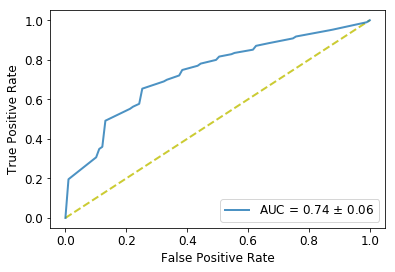

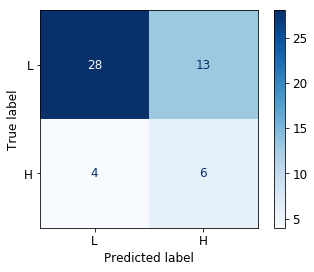

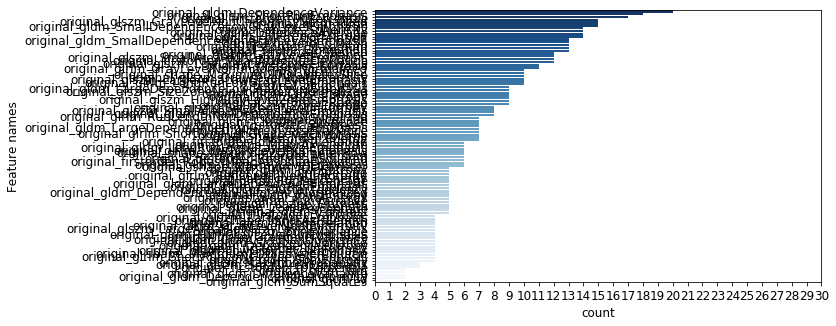

,Accuracy,Auc,F1 score,Sensitivity(TPR),Specificity(TNR)
XGB,0.66±0.09,0.74±0.06,0.38±0.06,0.6±0.12,0.67±0.13


In [2]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

xgb_cons = 0
xgb_accs = []
xgb_aucs = [] 
xgb_sens = []
xgb_spes = []
xgb_f1s = []
xgb_tprs = []
n=0
xgb_feature_set = []
mean_fpr = np.linspace(0, 1, 100)       
for i in range(0,300,10):    
    #统计循环次数
    n=n+1
    print('第',n,'次循环')
    print('随机种子数为：',i)
    
    #设置分类器
    sm = SMOTE(random_state=i)
    clf = xgboost.XGBClassifier(random_state=1,n_jobs=-1)
    xgboost.set_config(verbosity=0) 
    estimator = ([("sample", sm),("clf", clf)])
    pipeline = Mypipeline(estimator)
    
    #xgbECV特征选择
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
    rfecv.fit(X_data_1, y_data_1)
    print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
    names = list(X_data_1.columns[rfecv.support_])
    xgb_feature_set.append(names)
    select_features = X_data_1.loc[:, names]
    print('选择的特征子集为：', names)
    g_scores = rfecv.grid_scores_
    indices = np.argsort(g_scores)[::-1]
    print("Grid_Score: %f" % (g_scores[indices[0]]))
    
    #模型网格寻优
    model = Pipeline([("sample", sm),("clf", clf)])
    score={'AUC':'roc_auc', 'ACCURACY':'accuracy', 'RECALL':'recall', 'F1':'f1'}
    params = {'clf__colsample_bytree' : [0.1,0.3,0.7,0.9],
              'clf__gamma' : [0.2,0.4,0.6,0.8],
              'clf__learning_rate' : [0.01,0.03,0.07,0.09],
              'clf__max_depth' : [2,4,8,10],
              'clf__min_child_weight' : [1,3,7,9],
              'clf__n_estimators' : [2,4,8,10],          
              'clf__reg_alpha' : [1,3,7,9],
              'clf__reg_lambda' : [1,3,7,9],
              'clf__subsample' : [0.2,0.4,0.8,1]}  
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1,
                               refit='AUC',
                               return_train_score=True)
    grid_search.fit(select_features, y_data_1)
    print("模型最佳参数为：",grid_search.best_params_)
    print("模型最佳AUC为：", grid_search.best_score_)
    
    #用最优模型训练结果
    best_clf = grid_search.best_estimator_
    con = 0
    acc = []
    auc_ = [] 
    sen = []
    spe = []
    f1 = []
    tpr_ = []         
    for train_index, test_index in cv.split(select_features, y_data_1): 
        X_train = select_features.iloc[train_index] 
        y_train = y_data_1.iloc[train_index] 
        X_test = select_features.iloc[test_index]
        y_test = y_data_1.iloc[test_index]
        
        best_clf.fit(X_train, y_train)
        y_pred = best_clf.predict(X_test)
        proba = best_clf.predict_proba(X_test)[:,1]
        fpr,tpr,threshold = roc_curve(y_test, proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        
        tpr_.append(interp_tpr) 
        acc.append(accuracy_score(y_test, y_pred))
        auc_.append(roc_auc_score(y_test,proba))        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sen.append(tp/(tp+fn))
        spe.append(tn/(fp+tn))
        f1.append(f1_score(y_test, y_pred))
        
        a=confusion_matrix(y_test,y_pred)
        con=con+a
   
    xgb_tprs.append(np.mean(tpr_, axis=0))
    xgb_accs.append(np.mean(acc))
    xgb_aucs.append(np.mean(auc_))  
    xgb_sens.append(np.mean(sen))
    xgb_spes.append(np.mean(spe))
    xgb_f1s.append(np.mean(f1))
    xgb_cons=xgb_cons+con
    
#ROC曲线 
matplotlib.rcParams.update({'font.size': 12})
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
xgb_mean_tpr = np.mean(xgb_tprs, axis=0)
xgb_mean_tpr[-1] = 1.0
xgb_mean_auc = auc(mean_fpr, xgb_mean_tpr)
xgb_std_auc = np.std(xgb_aucs)
plt.plot(mean_fpr, xgb_mean_tpr, label=r'AUC = %0.2f $\pm$ %0.2f'% (xgb_mean_auc,xgb_std_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()

#混淆矩阵      
class_names=['L','H']
disp = ConfusionMatrixDisplay(confusion_matrix=np.around(xgb_cons/n),display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 

#特征频率图可视化
xgb_select_names = pd.concat([pd.DataFrame(xgb_feature_set[i],columns=['Feature names']) for i in range(n)])
xgb_result=pd.DataFrame(pd.value_counts(xgb_select_names['Feature names']))
plt.figure(figsize=(8, 5))
f = sns.countplot(y='Feature names',data=xgb_select_names, order=xgb_result.index, palette='Blues_r')
                  #'Blues_r')
f.set_xticks(range(n+1))
plt.show()

#模型结果
xgb_result_dict = {'Accuracy': ['±'.join([str(round(np.mean(xgb_accs),2)),str(round(np.std(xgb_accs),2))])], 
                'Auc': ['±'.join([str(round(np.mean(xgb_aucs),2)),str(round(np.std(xgb_aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(xgb_sens),2)),str(round(np.std(xgb_sens),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(xgb_spes),2)),str(round(np.std(xgb_spes),2))])], 
                'F1 score': ['±'.join([str(round(np.mean(xgb_f1s),2)),str(round(np.std(xgb_f1s),2))])] 
                }

xgb_result = pd.DataFrame(xgb_result_dict, index=['XGB'])
xgb_result

In [3]:
xgb_mean_tpr

array([0.        , 0.19565657, 0.2079798 , 0.22030303, 0.23262626,
       0.24494949, 0.25727273, 0.26959596, 0.28191919, 0.29424242,
       0.30656566, 0.34888889, 0.35966414, 0.4917385 , 0.49925898,
       0.50677946, 0.51429994, 0.52182043, 0.52934091, 0.53686139,
       0.54438187, 0.55190236, 0.56275617, 0.56997363, 0.57719108,
       0.65390797, 0.65912318, 0.66433838, 0.66955359, 0.6747688 ,
       0.67998401, 0.68519921, 0.69041442, 0.69896296, 0.70438019,
       0.70979742, 0.71521465, 0.72063187, 0.7483729 , 0.75263636,
       0.75689983, 0.7611633 , 0.76542677, 0.76969024, 0.78062037,
       0.78437879, 0.78813721, 0.79189562, 0.79565404, 0.79941246,
       0.81614506, 0.81918519, 0.82222531, 0.82526543, 0.82830556,
       0.83467901, 0.83741611, 0.8401532 , 0.84289029, 0.84562738,
       0.84836448, 0.85110157, 0.87056987, 0.87382323, 0.8770766 ,
       0.88032997, 0.88358333, 0.88665488, 0.88972643, 0.89279798,
       0.89586953, 0.89894108, 0.90201263, 0.90508418, 0.90815

In [4]:
xgb_mean_auc

0.7351722840073007

In [5]:
xgb_std_auc

0.059887390933017454

In [8]:
svm_mean_tpr=[0.        , 0.27367003, 0.27400673, 0.27434343, 0.27468013,
       0.27501684, 0.27535354, 0.27569024, 0.27602694, 0.27636364,
       0.27670034, 0.32037037, 0.32070707, 0.48420875, 0.48427609,
       0.48434343, 0.48441077, 0.48447811, 0.48454545, 0.48461279,
       0.48468013, 0.48474747, 0.51481481, 0.51488215, 0.51494949,
       0.59835017, 0.59841751, 0.59848485, 0.59855219, 0.59861953,
       0.59868687, 0.59875421, 0.59882155, 0.62222222, 0.62228956,
       0.6223569 , 0.62242424, 0.62249158, 0.67922559, 0.67929293,
       0.67936027, 0.67942761, 0.67949495, 0.67956229, 0.70296296,
       0.7030303 , 0.70309764, 0.70316498, 0.70323232, 0.70329966,
       0.78010101, 0.78030303, 0.78050505, 0.78070707, 0.78090909,
       0.78777778, 0.7879798 , 0.78818182, 0.78838384, 0.78858586,
       0.78878788, 0.7889899 , 0.82585859, 0.82606061, 0.82626263,
       0.82646465, 0.83666667, 0.83686869, 0.83707071, 0.83727273,
       0.83747475, 0.83767677, 0.83787879, 0.83808081, 0.83828283,
       0.88838384, 0.88845118, 0.89185185, 0.89191919, 0.89198653,
       0.89205387, 0.89212121, 0.89218855, 0.89225589, 0.89232323,
       0.89239057, 0.89245791, 0.91272727, 0.91333333, 0.91393939,
       0.91454545, 0.91515152, 0.91575758, 0.91636364, 0.9169697 ,
       0.91757576, 0.91818182, 0.91878788, 0.91939394, 1.        ]

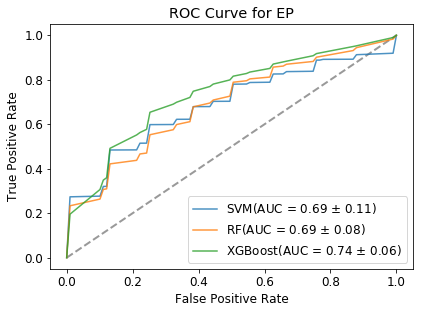

In [15]:
fig, ax = plt.subplots(figsize=(6.5,4.5))
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
ax.plot([0, 1], [0, 1], linestyle='--', lw=2,color='grey', 
         alpha=.8)

svm_mean_tpr[-1] = 1.0
#mean_auc_cmp = auc(mean_fpr, svm_mean_tpr)
ax.plot(mean_fpr, svm_mean_tpr, label=r'SVM(AUC = %0.2f $\pm$ %0.2f)'% (svm_mean_auc,svm_std_auc),lw=1.5, alpha=.8)

rf_mean_tpr[-1] = 1.0
#rf_mean_tpr = auc(mean_fpr, rf_mean_tpr)
ax.plot(mean_fpr, rf_mean_tpr, label=r'RF(AUC = %0.2f $\pm$ %0.2f)'% (rf_mean_auc,rf_std_auc),lw=1.5, alpha=.8)

xgb_mean_tpr[-1] = 1.0
#xgb_mean_auc = auc(mean_fpr, xgb_mean_auc)
ax.plot(mean_fpr, xgb_mean_tpr, label=r'XGBoost(AUC = %0.2f $\pm$ %0.2f)'% (xgb_mean_auc,xgb_std_auc),lw=1.5, alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC Curve for EP")
ax.legend(loc="lower right")

plt.show()

In [24]:
xgb_result

,Feature names
original_gldm_DependenceVariance,20
original_glrlm_ShortRunEmphasis,18
original_firstorder_90Percentile,17
original_gldm_SmallDependenceLowGrayLevelEmphasis,15
original_glcm_Idmn,15
original_glszm_GrayLevelNonUniformityNormalized,15
original_glcm_Correlation,14
original_shape_Sphericity,14
original_glcm_DifferenceAverage,14
original_glcm_DifferenceEntropy,14


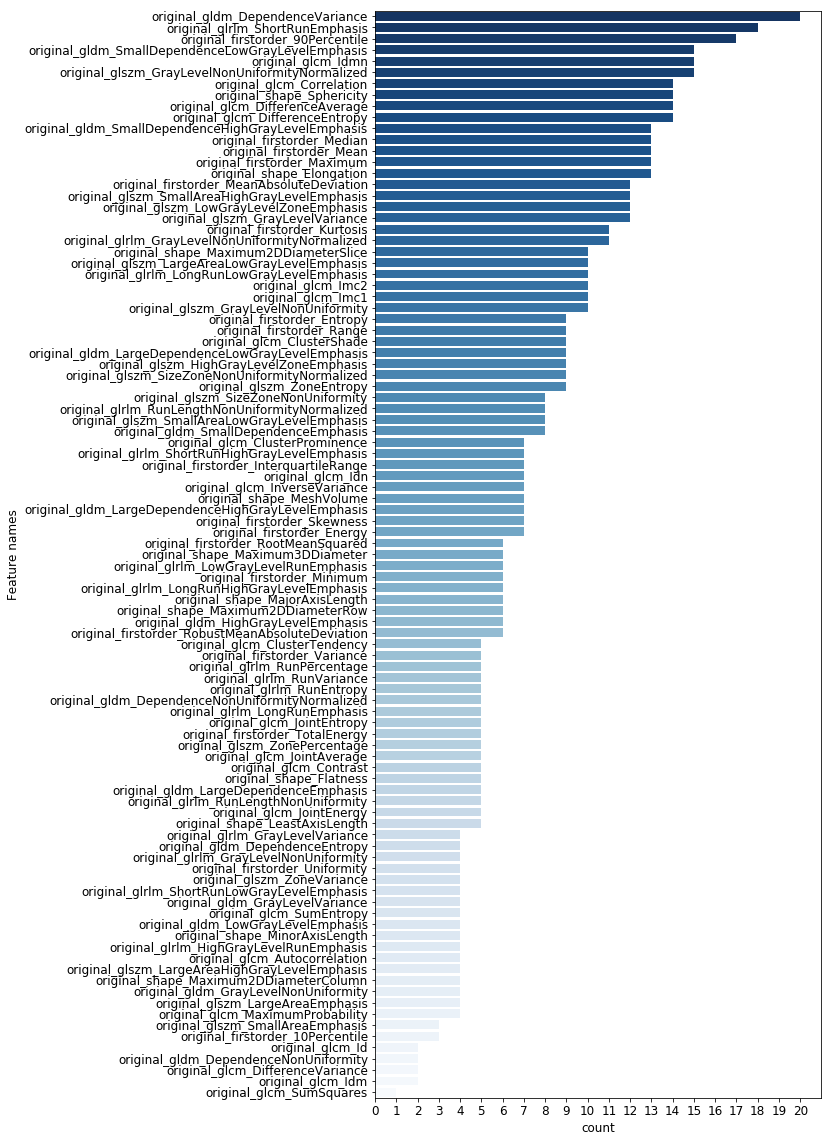

In [10]:
#特征频率图可视化
xgb_select_names = pd.concat([pd.DataFrame(xgb_feature_set[i],columns=['Feature names']) for i in range(n)])
xgb_result=pd.DataFrame(pd.value_counts(xgb_select_names['Feature names']))
plt.figure(figsize=(8, 20))
f = sns.countplot(y='Feature names',data=xgb_select_names, order=xgb_result.index, palette='Blues_r')
                  #'Blues_r')
f.set_xticks(range(21))
plt.show()